Write a python script/function, that realizes color segmentation of and image using the k-means method. Use the image 'bricks.png' from the data section.

The algorithm:

1. initialize k random seeds - color etalons (three-dimensional RGB vectors)
2. assign every pixel to one of the etalons (minimal euclidean distance in RGB space)
3. recompute every etalon as a mean of all assigned pixels
4. compute the change of every etalon (euclidean distance between the last and current one)


*   if the change of every etalon is bellow threshold, or max. number of
iterations reached, terminate
*   otherwise repeat from step 2

Use k=5, max. iterations=100, change threshold 0.0001 (when pixel colors are in range 0-1).

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


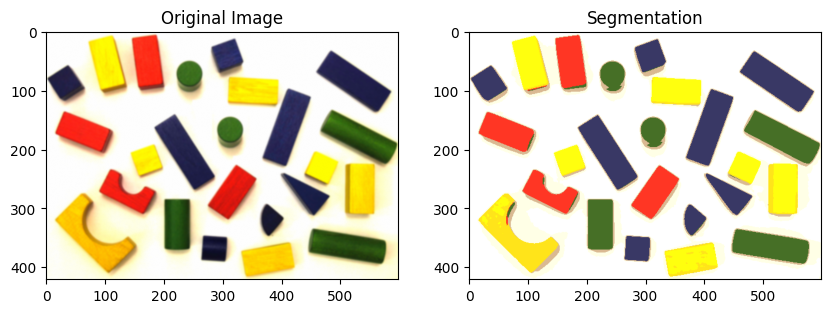

In [ ]:
import numpy as np
import cv2
import matplotlib.pyplot as plt


def initialize_centroids(pixels, k):
    centroids = np.empty((k, 3))
    centroids[0] = pixels[np.random.choice(pixels.shape[0])]  # Choosing first centroid randomly
    for i in range(1, k):
        # Calculating distance frm each pixel to closest centroid
        distances = np.min(np.linalg.norm(pixels[:, np.newaxis] - centroids[:i], axis=2), axis=1)
        probabilities = distances ** 2  # Use squared distance for probabilities
        probabilities /= probabilities.sum()  # Normalize to get a probability distribution
        centroids[i] = pixels[np.random.choice(pixels.shape[0], p=probabilities)]
    return centroids


def kmeans_color_segmentation(image_path, k=5, max_iterations=100, change_threshold=0.0001):
    # Loading and normalizing image (pixel values in the range [0, 1])
    image = cv2.imread(image_path)

    image_blur = cv2.GaussianBlur(image, (5, 5), 0)

    image = cv2.cvtColor(image_blur, cv2.COLOR_BGR2RGB) / 255.0  # Convert to RGB and normalize
    pixels = image.reshape(-1, 3)  # Reshape to a 2D array of pixels

    # Initialize k random seeds (color etalons) using K-means++ method
    centroids = initialize_centroids(pixels, k)

    for iteration in range(max_iterations):
        # 2. Assign each pixel to the nearest centroid (minimal Euclidean distance)
        distances = np.linalg.norm(pixels[:, np.newaxis] - centroids, axis=2)  # Euclidean distances
        labels = np.argmin(distances, axis=1)  # Assign each pixel to the nearest centroid

        # 3. Recompute centroids as the mean of assigned pixels
        new_centroids = np.array([pixels[labels == i].mean(axis=0) if np.any(labels == i) else centroids[i] for i in range(k)])

        # 4. Compute centroid changes (Euclidean distance between old and new centroids)
        centroid_shift = np.linalg.norm(centroids - new_centroids, axis=1)
        # print(f"k_means: iteration: {iteration} change: {centroid_shift}")

        # If change, below the threshold for all centroids, terminate
        if np.all(centroid_shift < change_threshold):
            break

        centroids = new_centroids  # Update centroids for next iteration

    # Reshaping labels back to the original image shape
    # segmented_image = centroids[labels].reshape(image.shape)
    segmented_image = np.clip(centroids[labels].reshape(image.shape), 0, 1)
    segmented_image = np.uint8(segmented_image * 255)  # Converting to 0-255 range
    segmented_image = cv2.convertScaleAbs(segmented_image, alpha=1.2, beta=10)  # Adjusting contrast and brightness


    # Display the original and segmented images
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(image)
    plt.title('Original Image')
    plt.axis('on')

    plt.subplot(1, 2, 2)
    plt.imshow(segmented_image)
    plt.title(f'Segmentation')
    plt.axis('on')

    plt.show()

image_path = '/content/drive/MyDrive/3DCV/2bricks.png'
kmeans_color_segmentation(image_path, k=8)
